In [31]:
# Headers
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from copy import deepcopy
from skimage.feature import greycomatrix, greycoprops
import cv2  
from numpy.linalg import det
from skimage import util, exposure
from math import sqrt, ceil
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io
from time import time

In [32]:
# global variables
black_value = np.float64(-1408.5106382978724)
images_filename = 'tr_im.nii'
masks_filename = 'tr_mask.nii'

In [33]:
def get_vals(mask):
    vals = []
    x, y = mask.shape
    for i in range(x):
        for j in range(y):
            if mask[i,j] not in vals:
                vals.append(mask[i][j])

    vals.remove(0)
    return vals

In [34]:
def apply_mask(img, mask, class_id):
    heigh, width = img.shape
    tmp = deepcopy(img)
    lineal_array = np.array(0)
    for x in range(heigh):
        for y in range(width):
            # Set pixel as black color if is not inside this mask
            if mask[x,y] != np.float64(class_id):
                tmp[x,y] = black_value
            # Count pixels inside this mask
            else:
                lineal_array = np.append(lineal_array, tmp[x,y])
    # In tmp is saved the image with mask applied
    # In lineal_array is saved just the mask's pixels
    lineal_array = np.delete(lineal_array, 0)
    return tmp, lineal_to_matrix(lineal_array)

In [35]:
def calculate_media_lineal_arr(array):
    length = array.shape[0]
    media = np.float64(0)
    for x in range(length):
        media += array[x]
    media = media/length
    return media

In [84]:
def lineal_to_matrix(lineal_array):
    sqrt_ = ceil(sqrt(lineal_array.shape[0]))
    media = calculate_media_lineal_arr(lineal_array)
    missing_values = sqrt_**2 - lineal_array.shape[0]
    print("missing ", missing_values)
    # Complete square matrix
    for x in range(missing_values):
        lineal_array = np.append(lineal_array, media)
    
    return lineal_array.reshape([sqrt_, sqrt_])

In [85]:
def show_slice_mask(slicei, mask):
    """ Function to display images and mask """
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(slicei.T,  cmap="gray", origin="lower")
    ax[0].set_title('Image')
    ax[1].imshow(mask.T, cmap="gray", origin="lower")
    ax[1].set_title('Mask')
    plt.show()

In [86]:
def glcm_properties(image):
    distancias = [1,2]
    #0 -> Oeste a este, -np.pi/2 -> Norte a sur
    angulos = [0, -np.pi/2]

    # Calculate properties for just one superpixel using the
    # respective mask  
    glcm = greycomatrix(image, 
                        distances = distancias, 
                        angles = angulos,
                        symmetric=True, 
                        normed=True)
                        
    energyResults = greycoprops(glcm, 'energy')
    contrastResults = greycoprops(glcm, 'contrast')
    correlationResults = greycoprops(glcm, 'correlation')
    
    return [np.mean(contrastResults), np.mean(energyResults), np.mean(correlationResults)]

In [87]:
def training(imgs, masks):
    height, width, num_images = imgs.shape
    # Class dictionary to store every property for this class as key
    classes_dict = {}
    # loop over the images
    for x in range(num_images):
        if x+1 % 10 == 0:
            print("{} imagenes procesadas".format(x))
        # Get every class in the current image
        classes = get_vals(masks[:,:,x])
        # loop for every class in the current image 
        for j in classes:
            if not int(j) in classes_dict:
                classes_dict[int(j)] = [[0, 0], [0, 0], [0, 0]]
            # getting the square matrix for the current class
            tmp, matrix_mask = apply_mask(imgs[:,:,x], masks[:,:,x], j)
            # Contrast, Correlation, Energy properties
            props = glcm_properties(matrix_mask.astype(np.uint8))
            # Adding every class's property values
            for z in range(len(props)):
                classes_dict[int(j)][z][0] += props[z]
                classes_dict[int(j)][z][1] += 1

    # Getting average for every class's property
    for id_ in classes_dict.keys():
        for z in range(3):
            classes_dict[id_][z][0] = classes_dict[id_][z][0]/classes_dict[id_][z][1]
            classes_dict[id_][z] = classes_dict[id_][z][0]
    #0: correlation, 1: contrast, 2: energy
    print(classes_dict)
    return classes_dict

In [88]:
def main():
    to_show = 3
    imgs = nib.load(images_filename).get_fdata()
    masks = nib.load(masks_filename).get_fdata()
    train = training(imgs, masks)
    #print(train)
    return train
    """
    #for x in range(3):
    for x in [25, 26, 27]:
        print("Image no ", x)
        classes = get_vals(masks[:,:,x])
        show_slice_mask(imgs[:,:,x], masks[:,:,x])
        for j in classes:
            tmp, matrix_mask = apply_mask(imgs[:,:,x], masks[:,:,x], j)
            print("class ", j)
            print(type(matrix_mask))
            #show_slice_mask(tmp, masks[:,:,x])
            show_slice_mask(tmp, matrix_mask)
            print(glcm_properties(matrix_mask.astype(np.uint8)))
            #create_matrix(tmp)
        #print(get_prop(imgs[:,:,x].astype(np.uint8), masks[:,:,x].astype(np.uint8)))
        #get_every_mask(imgs[:,:,x], masks[:,:,x])
    """

In [89]:
start_time = time()
train = main()
end_time = time() - start_time
print("Tiempo de entrenamiento: ", end_time)

missing  244
missing  145
missing  137
missing  164
missing  102
missing  23
missing  62
missing  46
missing  53
missing  108
missing  34
missing  108
missing  12
missing  29
missing  226
missing  430
missing  74
missing  62
missing  212
missing  139
missing  89
missing  148
missing  46
missing  81
missing  33
missing  180
missing  12
missing  134
missing  72
missing  69
missing  144
missing  13
missing  35
missing  93
missing  69
missing  47
missing  238
missing  85
missing  36
missing  131
missing  25
missing  43
missing  28
missing  22
missing  44
missing  39
missing  0
missing  3
missing  42
missing  52
missing  57
missing  27
missing  42
missing  67
missing  19
missing  97
missing  71
missing  59
missing  28
missing  102
missing  33
missing  24
missing  10
missing  38
missing  64
missing  86
missing  188
missing  40
missing  160
missing  53
missing  41
missing  134
missing  32
missing  31
missing  3
missing  27
missing  101
missing  8
missing  147
missing  24
missing  20
missing  

In [91]:
def getROI(img, segments):
    auxiliar = [] 
    for (i, segVal) in enumerate(np.unique(segments)): #Accediendo a cada superpixel
        # construct a mask for the segment
        mask = np.zeros(img.shape[:2], dtype = "uint8")
        mask[segments == segVal] = 255
        mask = cv2.bitwise_and(img, img, mask = mask)
        auxiliar.append(mask) #Se agrega cada una de las mascarar
    
    #print("Función getROI, len(auxiliar) = ", len(auxiliar))
    return auxiliar

In [ ]:
#funcion para segmentar superpíxeles
def SLIC(img, k):
    image = img_as_float(img)

    segments = slic(image, k, sigma = 5)
    # show the output of SLIC
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(mark_boundaries(image, segments))
    plt.axis("off")
    plt.show()

#Para cada máscara, segmentamos en superpixeles
def getSuperPixels(tmp, number):
    #aux = np.asarray(cv2.normalize(tmp, 0, 255, cv2.NORM_MINMAX), dtype=np.double)
    aux = np.asarray(cv2.normalize(tmp, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F),dtype=np.double)
    segments_slic = slic(aux, n_segments = number, compactness=0.28, sigma=0, enforce_connectivity=True, slic_zero=False)
    #print(f"Segmentos del algoritmo SLIC: {len(np.unique(segments_slic))}")
    
    ### Commented | Despliega imagen de superpixeles | 5-junio-2020
    # show the output of SLIC
    fig = plt.figure("Superpixels")
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(mark_boundaries(aux, segments_slic))
    plt.axis("off")
    plt.show()
    
    superpixels = np.asarray(getROI(aux, segments_slic)) #Lista de superpixeles

    res = []
    for i in range(len(superpixels)): #Iteramos sobre el número de superpixeles
        prueba = np.asarray(cv2.normalize(superpixels[i], 0, 255, cv2.NORM_MINMAX), dtype=int)
        valuePixel = np.unique(prueba)
        if (len(valuePixel) > 1):
            res.append(prueba)
    
    return res

In [94]:
def apply_superpixel(img, superpixel):
    heigh, width = img.shape
    lineal_array = np.array(0)
    for x in range(heigh):
        for y in range(width):
            # append pixels inside this superpixel
            if superpixel[x,y] == np.int64(8):
                lineal_array = np.append(lineal_array, img[x,y])
    # In tmp is saved the image with mask applied
    # In lineal_array is saved just the mask's pixels
    lineal_array = np.delete(lineal_array, 0)
    return lineal_to_matrix(lineal_array)

In [103]:
def classifier():
    imgs = nib.load(images_filename).get_fdata()
    masks = nib.load(masks_filename).get_fdata()
    for x in range(1):
        print("\nImage no ", x)
        superpixels = getSuperPixels(imgs[:,:,x], 300)
        print("SP reducidos = ", len(superpixels))
        for k in range(len(superpixels)):
            sp = apply_superpixel(imgs[:,:,x], superpixels[k])
            print("sp ", k)
            print(sp.shape)
            print(glcm_properties(sp.astype(np.uint8)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

Image no  0


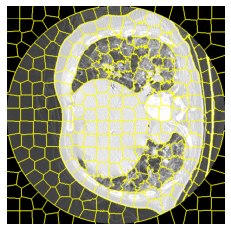

SP reducidos =  277
missing  0
sp  0
(512, 512)
[0.0, 1.0, 1.0]
missing  9
sp  1
(512, 512)
[0.0, 1.0, 1.0]
missing  14
sp  2
(512, 512)
[0.0, 1.0, 1.0]
missing  0
sp  3
(512, 512)


ValueError: The parameter `image` cannot be an empty array

In [104]:
classifier()